@Date         : 14-10-2025

@Author       : Felipe Gutiérrez Carilao

@Affiliation  : Universidad Andrés Bello

@Email        : f.gutierrezcarilao@uandresbello.edu

@Module       : analysis

@File         : Extracción de características.ipynb

In [5]:
# Librerias base
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchaudio.transforms as T
from termcolor import colored

# Extracción de características

Se selecciona uno de los datasets para visualizar características de audio

In [6]:
df = pd.read_csv("..//annotations//benchmark_musicbench.csv")

In [10]:
# Elegir una fila aleatoria del dataset
row = df.sample(n=1).iloc[0].to_dict()
ruta_base = ""

if (row['dataset'] == "fsl10k"):
    ruta_base = "../audio/fsl10k-dataset"
elif (row['dataset'] == "musicbench"):
    ruta_base = "../audio/musicbench-dataset"

# Carga el archivo de audio
audio_path = ruta_base + "/" + row['file_directory'] + "/" + row['file_name']
key = row['key']
try:
    metadata = torchaudio.info(audio_path)
    waveform, sample_rate = torchaudio.load(audio_path)
    n_samples = waveform.shape[1]
    print(colored(f"Archivo {audio_path} cargado correctamente.", 'green'))
except:
    print(colored(f"Error: No se pudo cargar el archivo {audio_path}", 'red'))

Archivo ../audio/musicbench-dataset/data_aug2/5ZX9Ig7XXsw_6.wav cargado correctamente.


Sampling Rate: 16000 Hz
Duration: 10.0 seconds


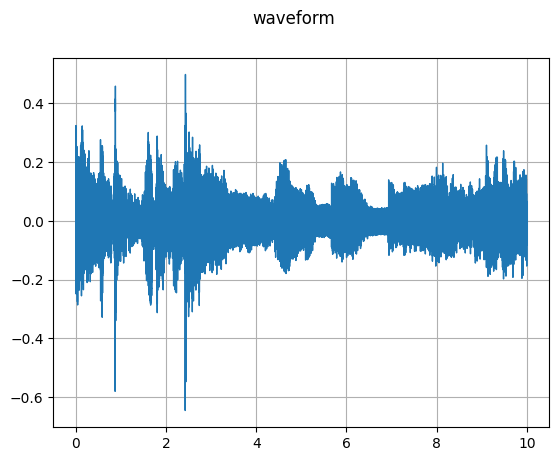

In [11]:
# Mostrar información básica
print(f"Sampling Rate: {sample_rate} Hz")
print(f"Duration: {round(n_samples / sample_rate, 2)} seconds")

# Graficar la forma de onda en el dominio del tiempo
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

plot_waveform(waveform, sample_rate)

c:\Users\ra1n\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:730: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


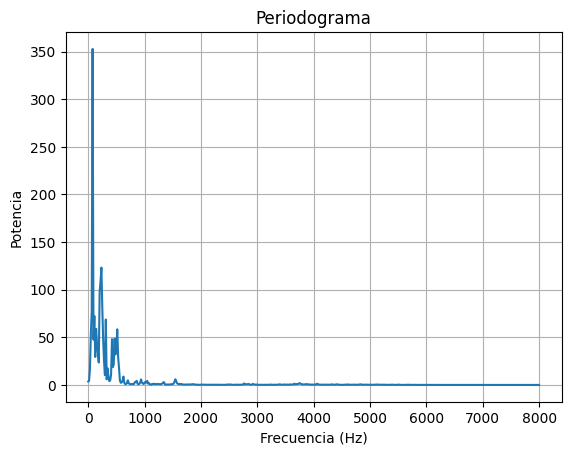

In [12]:
# Parámetros del STFT
n_fft = 1024
hop_length = n_fft // 4  # puedes ajustar esto

# Obtener STFT
stft = torch.stft(
    waveform, 
    n_fft=n_fft, 
    hop_length=hop_length, 
    return_complex=True
)

# Obtener el espectro de potencia (magnitude squared)
power_spectrum = stft.abs()**2  # (1, freq_bins, time_frames)

# Calcular frecuencias asociadas
freqs = torch.fft.rfftfreq(n_fft, d=1.0/sample_rate)

# Plotear periodograma promedio (a lo largo del tiempo)
periodograma = power_spectrum.mean(dim=-1).squeeze().numpy()

plt.plot(freqs.numpy(), periodograma)
plt.title("Periodograma")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Potencia")
plt.grid()
plt.show()

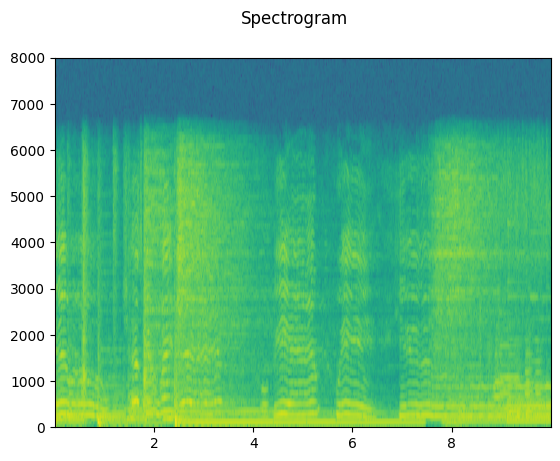

In [13]:
# Graficar el espectrograma
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

plot_specgram(waveform, sample_rate)

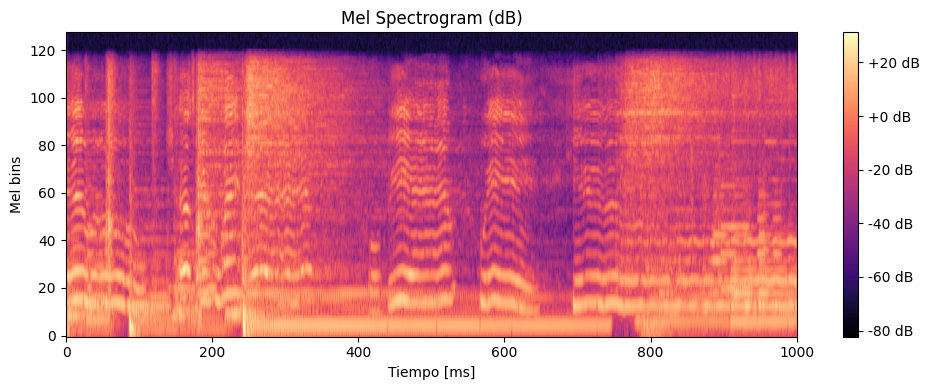

In [14]:

# Crear el transformador de MelSpectrogram
mel_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=160, # 10 ms hop
    win_length=400, # 25 ms window
    n_mels=128,
    f_min=0,
    f_max=8000
)

# Aplicar el transformador
mel_spec = mel_transform(waveform)  # (n_mels, time)

# Convertir a escala logarítmica (decibeles)
mel_spec_db = T.AmplitudeToDB()(mel_spec)

# Visualizar
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db[0].numpy(), origin="lower", aspect="auto", cmap="magma")
plt.title("Mel Spectrogram (dB)")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Mel bins")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

# Visualizando ejemplos

Los ejemplos mostrados son con el dataset de tipo logspec para de FSL10K

In [33]:
# (34862, 64, 937)
data = torch.load("..//datasets//benchmark_fsl10k_logspec_part0.pt")

spectrograms = data['logspec']  # Listado de tensores
labels = data['labels']  # Listado de categorias

for i, mel in enumerate(spectrograms):
    print(f"Col {i}")
    print(f"Tensor: {mel.shape}")
    print(f"Label: {labels[i]}")

Col 0
Tensor: torch.Size([120, 937])
Label: G:major
Col 1
Tensor: torch.Size([120, 937])
Label: E:minor
Col 2
Tensor: torch.Size([120, 937])
Label: F#:minor
Col 3
Tensor: torch.Size([120, 937])
Label: G#:minor
Col 4
Tensor: torch.Size([120, 937])
Label: D#:major
Col 5
Tensor: torch.Size([120, 937])
Label: D#:major
Col 6
Tensor: torch.Size([120, 937])
Label: G#:minor
Col 7
Tensor: torch.Size([120, 937])
Label: D#:major
Col 8
Tensor: torch.Size([120, 937])
Label: G#:minor
Col 9
Tensor: torch.Size([120, 937])
Label: F:minor
Col 10
Tensor: torch.Size([120, 937])
Label: A:major
Col 11
Tensor: torch.Size([120, 937])
Label: G#:minor
Col 12
Tensor: torch.Size([120, 937])
Label: G#:major
Col 13
Tensor: torch.Size([120, 937])
Label: A:major
Col 14
Tensor: torch.Size([120, 937])
Label: C:major
Col 15
Tensor: torch.Size([120, 937])
Label: B:major
Col 16
Tensor: torch.Size([120, 937])
Label: F#:major
Col 17
Tensor: torch.Size([120, 937])
Label: A:minor
Col 18
Tensor: torch.Size([120, 937])
Label: B

In [32]:
# Obtener el primer espectrograma
spec = spectrograms[0]
label = labels[0]

# Mostrar los primeros 10 valores de cada una de las primeras 5 bandas mel
print(f"Label: {label}")
for i in range(10):  # Primeras 5 bandas
    print(f"Banda {i}: {spec[i][:10].tolist()}")

Label: G:major
Banda 0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Banda 1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Banda 2: [0.000506210548337549, 0.0005512934294529259, 0.0005141072906553745, 0.00040805613389238715, 0.0002700563345570117, 0.00014266412472352386, 5.5060285376384854e-05, 3.0334169878187822e-06, 0.007945737801492214, 0.21254707872867584]
Banda 3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Banda 4: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Banda 5: [0.0003264729748480022, 0.0003594123700167984, 0.0003394888190086931, 0.0002739810151979327, 0.0001856217422755435, 0.00010179839591728523, 4.2039144318550825e-05, 3.142641162412474e-06, 0.006076563149690628, 0.19217808544635773]
Banda 6: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Banda 7: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Banda 8: [3.484977423795499e-05, 3.824153827736154e-05, 3.596210081013851e-05, 2.883337037928868e-05, 1.9332568626850843e-05, 1.0401709005236626e-

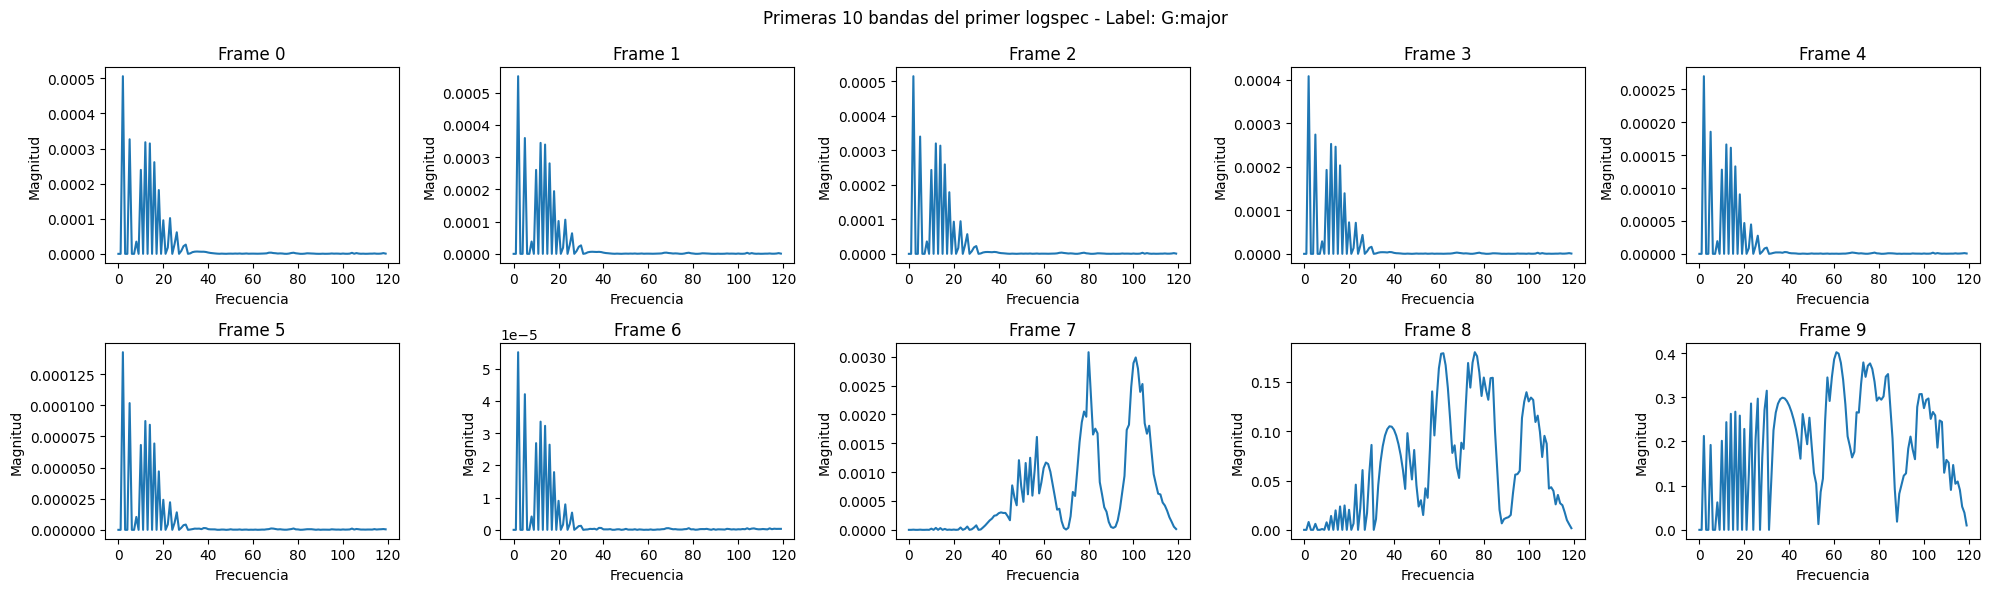

In [41]:
# Escoge el primer espectograma como ejemplo
idx = 0
spec = spectrograms[idx]
label = labels[idx]

# Visualizar las primeras 10 columnas (vectores de frecuencia a lo largo del tiempo)
fig, axs = plt.subplots(2, 5, figsize=(20, 6))
axs = axs.flatten()

for i in range(10):
    axs[i].plot(spec[:, i].numpy()) # Cada columna es un vector de 128 frecuencias
    axs[i].set_title(f"Frame {i}")
    axs[i].set_xlabel("Frecuencia")
    axs[i].set_ylabel("Magnitud")

# Visualizar bandas Mel
plt.suptitle(f"Primeras 10 bandas del primer logspec - Label: {label}")
plt.tight_layout()
plt.show()

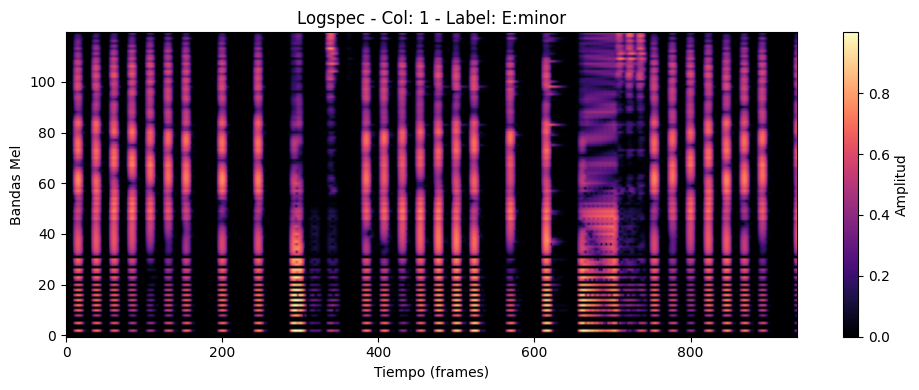

In [42]:
# Seleccionar el primer cqt espectrograma
idx = 1
sepc = spectrograms[idx]
label = labels[idx]

# Visualizar
plt.figure(figsize=(10, 4))
plt.imshow(spec.numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title(f"Logspec - Col: {idx} - Label: {label}")
plt.xlabel("Tiempo (frames)")
plt.ylabel("Bandas Mel")
plt.colorbar(label="Amplitud")
plt.tight_layout()
plt.show()

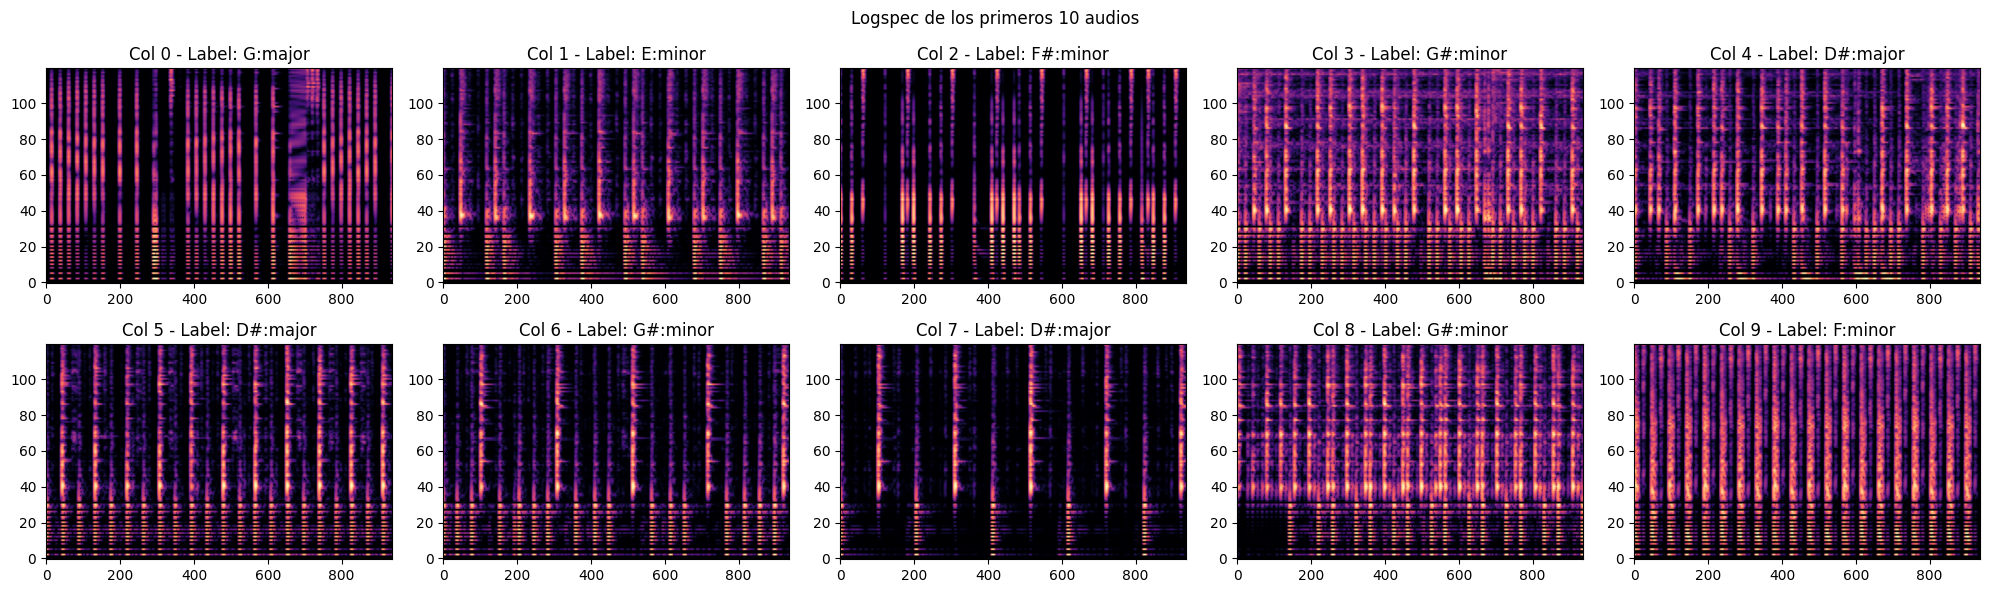

In [43]:
# Asegurar compatibilidad con imshow
fig, axs = plt.subplots(2, 5, figsize=(20, 6))
axs = axs.flatten()

for i in range(10):
    axs[i].imshow(spectrograms[i].numpy(), origin='lower', aspect='auto', cmap='magma')
    axs[i].set_title(f"Col {i} - Label: {labels[i]}")

plt.suptitle("Logspec de los primeros 10 audios")
plt.tight_layout()
plt.show()